In [73]:
from dispel4py.workflow_graph import WorkflowGraph 
from dispel4py.provenance import *
from dispel4py.new.processor  import *
import time
import random
import numpy
import traceback 
import backtrader as bt
from dispel4py.base import create_iterative_chain, GenericPE, ConsumerPE, IterativePE, SimpleFunctionPE
from dispel4py.new.simple_process import process_and_return

import IPython
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
import networkx as nx

sns.set(style="white")

class Start(GenericPE):

    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        #self.prov_cluster="myne"
    
    def _process(self,inputs):
        
        if 'iterations' in inputs:
            inp=inputs['iterations']
             
            self.write('output',inp,metadata={'val':inp})
            
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'


class StockGenerator(GenericPE):

    def __init__(self, stock_name, price):
        GenericPE.__init__(self)
        self._add_input('iterations')
        self._add_output('output')
        self.stockName = stock_name
        self.price = price
        self.maxVolatility = 5.0
        #self.prov_cluster="myne"
    
    def _process(self,data):
        output = {}
        output[self.stockName] = {}
        
        for day in range(data['iterations'][0]):
            volatility = random.random() * self.price * self.maxVolatility / 100
            self.price += (random.random() * 2 - 1) * volatility
            output[self.stockName][day] = self.price
            
        self.write('output', output, metadata={'stock_name': self.stockName, 'max_voladility': self.maxVolatility})
        
        #Uncomment this line to associate this PE to the mycluster provenance-cluster 
        #self.prov_cluster ='mycluster'
            
class Accumulator(GenericPE):
    
    def __init__(self, total_input_size):
        GenericPE.__init__(self)
        self._add_input('stocks')
        self._add_output('output')
        self.stocks_data = {}
        self.size = total_input_size
    
    
    def _process(self, data):
        if (len(self.stocks_data) + 1 == 4):
            self.stocks_data.update(data['stocks'])

            for i in self.stocks_data:

                keys = self.stocks_data[i].keys()
                values = self.stocks_data[i].values()
                plt.xlabel('Days')
                plt.ylabel('Stock Price')
                plt.title(i)

                plt.plot(keys, values)        
            plt.show()
            
            print "End of data collection"
            
            ## IF got feedback mechanism here, can try to limit down the days 
            ## of data 
            self.write('output', self.stocks_data)
        else:
            self.stocks_data.update(data['stocks'])
            print "Writing Data"
            print len(self.stocks_data)
            
            
        
class Broker(GenericPE):
    
    def __init__(self, moneyOwned):
        GenericPE.__init__(self)
        self._add_input('stocks')
        self._add_output('output')
        self.moneyOwned = moneyOwned
        self.stockOwned = {}
        self.treshold = 5.0 ## treshold for buy & sell
        
    def _process(self, data):        
        # print data
        print "End in the broker"

SETTING NAME: Start
SETTING NAME: Accumulator
SETTING NAME: Broker
SETTING NAME: StockGenerator
SETTING NAME: StockGenerator
SETTING NAME: StockGenerator
SETTING NAME: StockGenerator


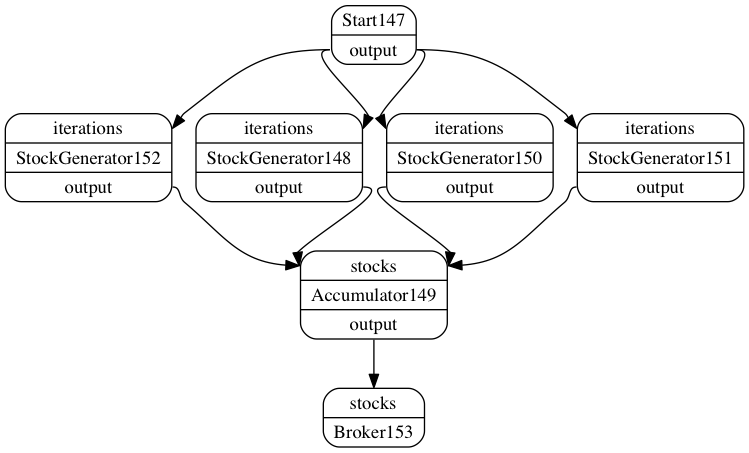

Done visualising graph


In [74]:
#####################################################################################################

#Declare workflow inputs: (each iteration prduces a batch_size of samples at the specified sampling_rate)
# number of projections = iterations/batch_size at speed defined by sampling rate    

inputs_stock = {
    0: { 
        'name': 'google',
        'price': 10.0 
    },
    1:{ 
        'name': 'facebook',
        'price': 8.0 
    },
    2:{ 
        'name': 'apple',
        'price': 9.0 
    },
    3:{ 
        'name': 'microsoft',
        'price': 11.0 
    },
} 

input_data = {
    "Start": [{"iterations": [1000]}]
}

# Instantiates the Workflow Components  
# and generates the graph based on parameters

def createWf():
    graph = WorkflowGraph()
    
    start = Start() 
    accumulate = Accumulator(len(inputs_stock))
    broke = Broker(100000)
    stimulator = {}
    
    for i in range(inputs_stock.__len__()):
        stimulator[i] = StockGenerator(inputs_stock[i]['name'], inputs_stock[i]['price'])
    
    for i in range(stimulator.__len__()):
        graph.connect(start, 'output', stimulator[i], 'iterations')
        graph.connect(stimulator[i], 'output', accumulate, 'stocks') 
    
    graph.connect(accumulate, 'output', broke, 'stocks')
    
    return graph
        

graph=createWf()
#Visualise the graph
from dispel4py.visualisation import display
display(graph)

print "Done visualising graph"

SETTING NAME: SimpleProcessingPE
Writing Data
1
Writing Data
2
Writing Data
3


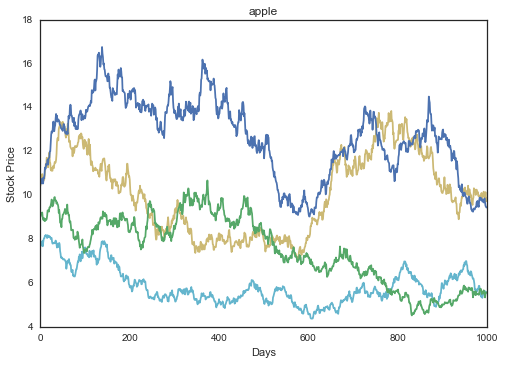

End of data collection
End in the broker
SimplePE: Processed 1 iteration.
ELAPSED TIME: 0.188738107681


In [75]:
#Launch in simple process
start_time = time.time()
process_and_return(graph, input_data)
elapsed_time = time.time() - start_time
print ("ELAPSED TIME: "+str(elapsed_time))